In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [2]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend

Using notebook 3d backend.


# Phoneme Sequence

In [3]:
ref = 'bipolar'
task = 'PhonemeSequence'

hga_path = BIDSPath(
    root=f'../results/{task}({ref})',
    datatype='HGA',
    suffix='time',
    check=False,
)

HGAs = []
for path in tqdm(hga_path.match()):
    df = pd.read_csv(path)
    HGAs.append(df)
    
HGAs = pd.concat(HGAs, ignore_index=True)
HGAs = HGAs[HGAs['roi'].isin([
    'STG','INS','SMC'
])]
HGAs.head()

100%|██████████| 90/90 [00:01<00:00, 55.11it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,label,x,y,z
5760,-1.000000,D0022_LPIF3-4,0.075033,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5762,-0.992188,D0022_LPIF3-4,0.103754,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5764,-0.984375,D0022_LPIF3-4,0.128319,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5766,-0.976562,D0022_LPIF3-4,0.126154,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5768,-0.968750,D0022_LPIF3-4,0.102751,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079


In [4]:
# load stats

stats_path = BIDSPath(
    root=f'../results/{task}(roi)({ref})',
    datatype='HGA',
    suffix='roimask',
    check=False,
)
stats = []
for path in tqdm(stats_path.match()):
    df = pd.read_csv(path)
    stats.append(df)
    
stats = pd.concat(stats, ignore_index=True)
stats = stats[stats['roi'].isin([
    'STG','INS','SMC'
])]
stats.head()


0it [00:00, ?it/s]


ValueError: No objects to concatenate

In [5]:
def sort_HGA(HGAs, hemi, description, roi):
    sub_df = HGAs[(HGAs.hemi == hemi) 
                  & (HGAs.description == description)
                  & (HGAs.roi == roi)].copy()

    # pivot 成 (channel, time) 矩阵
    hga_mat = sub_df.pivot(index='channel', columns='time', values='value')
    mask_mat = sub_df.pivot(index='channel', columns='time', values='mask')

    # 找每个 channel 第一个 significant 的时间点
    first_sig_time = []
    for ch in hga_mat.index:
        sig_times = mask_mat.loc[ch][mask_mat.loc[ch] == True].index
        if len(sig_times) > 0:
            first_sig_time.append(sig_times.min())
        else:
            first_sig_time.append(np.inf)  # 没有显著点的放最后

    # 按首次显著时间排序
    sort_idx = np.argsort(first_sig_time)
    hga_mat = hga_mat.iloc[sort_idx]
    mask_mat = mask_mat.iloc[sort_idx]

    # mask 掉 insignificant 的点
    hga_masked = np.where(mask_mat, hga_mat, np.nan)
    
    return hga_masked

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2258052/2238891590.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2258052/2238891590.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


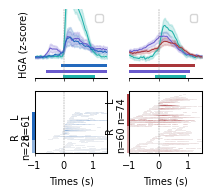

In [ ]:
left_percetion = sort_HGA(HGAs, 'L', 'perception', 'INS')
right_percetion = sort_HGA(HGAs, 'R', 'perception', 'INS')
left_production = sort_HGA(HGAs, 'L', 'production', 'INS')
right_production = sort_HGA(HGAs, 'R', 'production', 'INS')

perception = np.concatenate([right_percetion, left_percetion])
production = np.concatenate([right_production, left_production])

n_perception,n_production = perception.shape[0], production.shape[0]

# to the same shape, pad with NaN to the end, not the beginning
perception = np.pad(
    perception,
    ((0, n_production - n_perception), (0, 0)),
    'constant',
    constant_values=np.nan
)

ax2_height = 0.01*(n_production + n_perception)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(5.5*cm, (ax2_height + 2.5)*cm),
                               gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2.5, ax2_height]})


plt.subplots_adjust(wspace=0.3)

band_h, gap = 0.015, 0.01
order = ['STG', 'SMC', 'INS']

sns.lineplot(
    data=HGAs[HGAs.description == 'perception'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[0],
    palette=[stg_color, smc_color, blue],
    legend=False,
    lw=0.75
)

sns.lineplot(
    data=HGAs[HGAs.description == 'production'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[1],
    palette=[stg_color, smc_color, red],
    legend=False,
    lw=.75
)

# ============ 画 significance bars 在 y<0 区域 ============
band_h = 0.06  # 每个 bar 的高度
gap = 0.06    # bar 之间的间隔
y_base = -0.45  # 从 y=-0.25 开始往上画
colors = {'STG': stg_color, 'SMC': smc_color, 'INS': blue}  # perception 用 blue
colors_prod = {'STG': stg_color, 'SMC': smc_color, 'INS': red}  # production 用 red

for ax_idx, (ax, desc, col_map) in enumerate([
    (ax1[0], 'perception', colors),
    (ax1[1], 'production', colors_prod)
]):
    for k, roi in enumerate(order):
        df_roi = stats[(stats['roi'] == roi) & (stats['description'] == desc)].sort_values('time')
        if df_roi.empty:
            continue
        
        sig = df_roi['mask'].astype(bool)
        runs = (sig != sig.shift()).cumsum()
        
        y_bottom = y_base + k * (band_h + gap)
        
        for _, g in df_roi.groupby(runs):
            if not g['mask'].iloc[0]:  # 只画 significant 的区间
                continue
            t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
            ax.fill_between(
                [t0, t1], 
                y_bottom, 
                y_bottom + band_h,
                color=col_map[roi], 
                alpha=1, 
                linewidth=0
            )

ax1[1].spines['left'].set_visible(False)
ax1[1].set_yticks([])

ax2[0].pcolormesh(HGAs.time.unique(),
               np.arange(perception.shape[0]), 
               perception,
               cmap=blues,
               rasterized=True
              )

ax2[1].pcolormesh(HGAs.time.unique(),
               np.arange(production.shape[0]), 
               production,
               cmap=reds,
               rasterized=True
              )

# ============ 左边加 bar 表示左右脑 ============
# perception
n_left_p = left_percetion.shape[0]
n_right_p = right_percetion.shape[0]
n_total_p = perception.shape[0]

# 画 bar（用 axvspan 或 bar）
bar_width = 0.08  # bar 宽度（相对于 x 轴范围）
x_left = -1 - bar_width  # bar 的 x 位置（在 heatmap 左边）

# 左脑 bar（下半部分）
ax2[0].barh(y=n_right_p + n_left_p/2, width=bar_width, height=n_left_p, 
            left=x_left, color=blue, edgecolor='none', clip_on=False)
# 右脑 bar（上半部分）
ax2[0].barh(y=n_right_p/2, width=bar_width, height=n_right_p, 
            left=x_left, color=blue, alpha=0.5, edgecolor='none', clip_on=False)

# 标注
ax2[0].text(x_left - 0.02, n_right_p + n_left_p/2, f'L\nn={n_left_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[0].text(x_left - 0.02, n_right_p/2, f'R\nn={n_right_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)

# production
n_left_d = left_production.shape[0]
n_right_d = right_production.shape[0]
n_total_d = production.shape[0]

ax2[1].barh(y=n_right_d + n_left_d/2, width=bar_width, height=n_left_d, 
            left=x_left, color=red, edgecolor='none', clip_on=False)
ax2[1].barh(y=n_right_d/2, width=bar_width, height=n_right_d, 
            left=x_left, color=red, alpha=0.5, edgecolor='none', clip_on=False)

ax2[1].text(x_left - 0.02, n_right_d + n_left_d/2, f'L\nn={n_left_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[1].text(x_left - 0.02, n_right_d/2, f'R\nn={n_right_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)


for ax in ax1:
    # remove the top, right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    # ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.35)
    
    ax.set_ylim(-0.45, 1)
    ax.set_xlim(-1, 1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('HGA (z-score)', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)

    ax.legend(fontsize=fontsize)
    
ax1[1].set_ylabel('')

for ax in ax2:
    # remove the top, right spines
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.set_xlim(-1, 1.5)
    ax.set_yticks([])
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.set_xlabel('Times (s)', fontsize=fontsize)

fig.savefig(f'../img/fig1/fig1_HGA_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

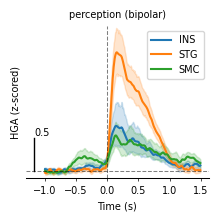

In [ ]:
fig, ax = plt.subplots(figsize=(6*cm, 5*cm))

description = 'perception'
thresh = 0.5
band_h, gap = 0.015, 0.01
order = ['INS', 'STG', 'SMC']

sns.lineplot(
    data=HGAs[HGAs.description == description],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax,
)

ave_stats[ave_stats.description == description].pivot(index='roi', columns='time', values='mask')

for k, roi in enumerate(order):
    df_roi = ave_stats[ave_stats['roi'] == roi].sort_values('time')
    sig  = (df_roi['mask'] >= thresh)
    runs = (sig != sig.shift()).cumsum()
    ymin = k * (band_h + gap)
    ymax = ymin + band_h
    for _, g in df_roi.groupby(runs):
        if not g['mask'].ge(thresh).iloc[0]:
            continue
        t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
        # ax.axvspan(t0, t1, ymin=ymin, ymax=ymax, color=f'C{k}', alpha=0.8, linewidth=0)

# remove spines
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.set_xlabel('Time (s)', fontsize=fontsize)
ax.set_ylabel('HGA (z-scored)', fontsize=fontsize)
ax.set_title(f'{description} (bipolar)', fontsize=fontsize)

# set legend font size
ax.legend(fontsize=fontsize)

for ax in fig.axes:
    
    ax.set_ylim(-0.2, 2.2)
    ax.tick_params(labelsize=7, width=0.5, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    # remove y ticks
    ax.set_yticks([])
    
    # 0.5 scale
    x0, x1 = ax.get_xlim()
    # 0.02 of the x axis
    x_bar = x0 - 0.02 * (x1 - x0)
    y0 = 0.0
    y1 = y0 + 0.5   # 标尺长度 0.5

    ax.plot([x_bar, x_bar], [y0, y1], color='k', lw=1)
    ax.text(x_bar, y1, '0.5', ha='left', va='bottom', fontsize=fontsize)
    
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.5, lw=0.75)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5, lw=0.75)
    
fig.savefig(f'../img/HGAs/time_HGA_{description}.svg', dpi=300, bbox_inches='tight')

# Sentence Rep

In [15]:
ref = 'bipolar'
task = 'SentenceRep'

hga_path = BIDSPath(
    root=f'../results/{task}({ref})',
    datatype='HGA',
    suffix='time',
    check=False,
)

HGAs = []
for path in tqdm(hga_path.match()):
    df = pd.read_csv(path)
    HGAs.append(df)
    
HGAs = pd.concat(HGAs, ignore_index=True)
HGAs = HGAs[HGAs['roi'].isin([
    'STG','INS','SMC'
])]

HGAs = HGAs[HGAs.description == 'LM']
HGAs.head()

100%|██████████| 218/218 [00:01<00:00, 185.75it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,x,y,z
2817,-0.5,D0005_LTG15-16,-0.303616,False,STG,L,D0005,LM,SentenceRep,Audio,-69.639740,-38.151283,4.609248
2818,-0.5,D0005_LTG5-6,0.270508,False,STG,L,D0005,LM,SentenceRep,Audio,-65.565052,-12.541510,6.143881
2819,-0.5,D0005_LTG14-15,-0.089681,False,STG,L,D0005,LM,SentenceRep,Audio,-68.886726,-28.295294,0.243498
2820,-0.5,D0005_LTG4-5,-0.022498,False,STG,L,D0005,LM,SentenceRep,Audio,-63.895071,-1.988314,1.863490
2822,-0.5,D0005_LTG3-4,0.040170,False,STG,L,D0005,LM,SentenceRep,Audio,-61.035833,7.066387,-2.862520


In [16]:
def sort_HGA(HGAs, hemi, description, roi):
    sub_df = HGAs[(HGAs.hemi == hemi) 
                  & (HGAs.phase == description)
                  & (HGAs.roi == roi)].copy()

    # pivot 成 (channel, time) 矩阵
    hga_mat = sub_df.pivot(index='channel', columns='time', values='value')
    mask_mat = sub_df.pivot(index='channel', columns='time', values='mask')

    # 找每个 channel 第一个 significant 的时间点
    first_sig_time = []
    for ch in hga_mat.index:
        sig_times = mask_mat.loc[ch][mask_mat.loc[ch] == True].index
        if len(sig_times) > 0:
            first_sig_time.append(sig_times.min())
        else:
            first_sig_time.append(np.inf)  # 没有显著点的放最后

    # 按首次显著时间排序
    sort_idx = np.argsort(first_sig_time)
    hga_mat = hga_mat.iloc[sort_idx]
    mask_mat = mask_mat.iloc[sort_idx]

    # mask 掉 insignificant 的点
    hga_masked = np.where(mask_mat, hga_mat, np.nan)
    
    return hga_masked

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2258052/597788573.py:160: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2258052/597788573.py:160: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


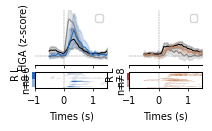

In [24]:
left_percetion = sort_HGA(HGAs, 'L', 'Audio', 'INS')
right_percetion = sort_HGA(HGAs, 'R', 'Audio', 'INS')
left_production = sort_HGA(HGAs, 'L', 'Go', 'INS')
right_production = sort_HGA(HGAs, 'R', 'Go', 'INS')

perception = np.concatenate([right_percetion, left_percetion])
production = np.concatenate([right_production, left_production])

n_perception,n_production = perception.shape[0], production.shape[0]

# to the same shape, pad with NaN to the end, not the beginning
perception = np.pad(
    perception,
    ((0, n_production - n_perception), (0, 0)),
    'constant',
    constant_values=np.nan
)

ax2_height = 0.02*(n_production + n_perception)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(5.5*cm, (ax2_height + 2)*cm),
                               gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2, ax2_height]})


plt.subplots_adjust(wspace=0.3)

band_h, gap = 0.015, 0.01
order = ['STG', 'SMC', 'INS']

sns.lineplot(
    data=HGAs[HGAs.phase == 'Audio'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[0],
    palette=['gray','black', blue],
    legend=False,
    lw=0.75
)

sns.lineplot(
    data=HGAs[HGAs.phase == 'Go'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[1],
    palette=['gray', 'black', orange],
    legend=False,
    lw=.75
)

# # ============ 画 significance bars 在 y<0 区域 ============
# band_h = 0.06  # 每个 bar 的高度
# gap = 0.06    # bar 之间的间隔
# y_base = -0.45  # 从 y=-0.25 开始往上画
# colors = {'STG': 'gray', 'SMC': 'black', 'INS': blue}  # perception 用 blue
# colors_prod = {'STG': 'gray', 'SMC': 'black', 'INS': red}  # production 用 red

# for ax_idx, (ax, desc, col_map) in enumerate([
#     (ax1[0], 'perception', colors),
#     (ax1[1], 'production', colors_prod)
# ]):
#     for k, roi in enumerate(order):
#         df_roi = stats[(stats['roi'] == roi) & (stats['description'] == desc)].sort_values('time')
#         if df_roi.empty:
#             continue
        
#         sig = df_roi['mask'].astype(bool)
#         runs = (sig != sig.shift()).cumsum()
        
#         y_bottom = y_base + k * (band_h + gap)
        
#         for _, g in df_roi.groupby(runs):
#             if not g['mask'].iloc[0]:  # 只画 significant 的区间
#                 continue
#             t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
#             ax.fill_between(
#                 [t0, t1], 
#                 y_bottom, 
#                 y_bottom + band_h,
#                 color=col_map[roi], 
#                 alpha=1, 
#                 linewidth=0
#             )

ax1[1].spines['left'].set_visible(False)
ax1[1].set_yticks([])

ax2[0].pcolormesh(HGAs.time.unique(),
               np.arange(perception.shape[0]), 
               perception,
               cmap=blues,
              )

ax2[1].pcolormesh(HGAs.time.unique(),
               np.arange(production.shape[0]), 
               production,
               cmap=oranges,
              )

# ============ 左边加 bar 表示左右脑 ============
# perception
n_left_p = left_percetion.shape[0]
n_right_p = right_percetion.shape[0]
n_total_p = perception.shape[0]

# 画 bar（用 axvspan 或 bar）
bar_width = 0.08  # bar 宽度（相对于 x 轴范围）
x_left = -1 - bar_width  # bar 的 x 位置（在 heatmap 左边）

# 左脑 bar（下半部分）
ax2[0].barh(y=n_right_p + n_left_p/2, width=bar_width, height=n_left_p, 
            left=x_left, color=blue, edgecolor='none', clip_on=False)
# 右脑 bar（上半部分）
ax2[0].barh(y=n_right_p/2, width=bar_width, height=n_right_p, 
            left=x_left, color=blue, alpha=0.5, edgecolor='none', clip_on=False)

# 标注
ax2[0].text(x_left - 0.02, n_right_p + n_left_p/2, f'L\nn={n_left_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[0].text(x_left - 0.02, n_right_p/2, f'R\nn={n_right_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)

# production
n_left_d = left_production.shape[0]
n_right_d = right_production.shape[0]
n_total_d = production.shape[0]

ax2[1].barh(y=n_right_d + n_left_d/2, width=bar_width, height=n_left_d, 
            left=x_left, color=red, edgecolor='none', clip_on=False)
ax2[1].barh(y=n_right_d/2, width=bar_width, height=n_right_d, 
            left=x_left, color=red, alpha=0.5, edgecolor='none', clip_on=False)

ax2[1].text(x_left - 0.02, n_right_d + n_left_d/2, f'L\nn={n_left_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[1].text(x_left - 0.02, n_right_d/2, f'R\nn={n_right_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)


for ax in ax1:
    # remove the top, right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.35)
    
    ax.set_ylim(-0.45, 2.5)
    ax.set_xlim(-1, 1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('HGA (z-score)', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)

    ax.legend(fontsize=fontsize)
    
ax1[1].set_ylabel('')

for ax in ax2:
    # remove the top, right spines
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.set_xlim(-1, 1.5)
    ax.set_yticks([])
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.set_xlabel('Times (s)', fontsize=fontsize)

fig.savefig(f'../img/fig1/fig1_HGA_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

# TIMIT

In [25]:
ref = 'bipolar'
task = 'TIMIT'

hga_path = BIDSPath(
    root=f'../results/{task}({ref})',
    datatype='HGA',
    suffix='time',
    check=False,
)

HGAs = []
for path in tqdm(hga_path.match()):
    df = pd.read_csv(path)
    HGAs.append(df)
    
HGAs = pd.concat(HGAs, ignore_index=True)
HGAs = HGAs[HGAs['roi'].isin([
    'STG','INS','SMC'
])]

HGAs.head()

100%|██████████| 29/29 [00:00<00:00, 46.92it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,x,y,z
1,-0.500000,D0028_LPST5-6,-0.011670,False,STG,L,D0028,passive,TIMIT,NaN,-70.274789,-34.939866,-3.567536
4,-0.500000,D0028_LPST3-4,-0.019878,False,STG,L,D0028,passive,TIMIT,NaN,-59.966877,-34.272873,-3.822377
9,-0.500000,D0028_LPST4-5,0.017776,False,STG,L,D0028,passive,TIMIT,NaN,-65.033839,-34.563602,-3.695333
13,-0.492188,D0028_LPST5-6,-0.010642,False,STG,L,D0028,passive,TIMIT,NaN,-70.274789,-34.939866,-3.567536
16,-0.492188,D0028_LPST3-4,-0.012995,False,STG,L,D0028,passive,TIMIT,NaN,-59.966877,-34.272873,-3.822377


In [26]:
def sort_HGA(HGAs, hemi, description, roi):
    sub_df = HGAs[(HGAs.hemi == hemi) 
                  & (HGAs.roi == roi)].copy()

    # pivot 成 (channel, time) 矩阵
    hga_mat = sub_df.pivot(index='channel', columns='time', values='value')
    mask_mat = sub_df.pivot(index='channel', columns='time', values='mask')

    # 找每个 channel 第一个 significant 的时间点
    first_sig_time = []
    for ch in hga_mat.index:
        sig_times = mask_mat.loc[ch][mask_mat.loc[ch] == True].index
        if len(sig_times) > 0:
            first_sig_time.append(sig_times.min())
        else:
            first_sig_time.append(np.inf)  # 没有显著点的放最后

    # 按首次显著时间排序
    sort_idx = np.argsort(first_sig_time)
    hga_mat = hga_mat.iloc[sort_idx]
    mask_mat = mask_mat.iloc[sort_idx]

    # mask 掉 insignificant 的点
    hga_masked = np.where(mask_mat, hga_mat, np.nan)
    
    return hga_masked

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2258052/651900541.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


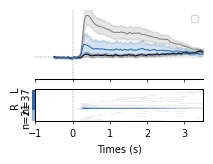

In [38]:
left_percetion = sort_HGA(HGAs, 'L', 'Passive', 'INS')
right_percetion = sort_HGA(HGAs, 'R', 'Passive', 'INS')

perception = np.concatenate([right_percetion, left_percetion])

n_perception,n_production = perception.shape[0], production.shape[0]

# to the same shape, pad with NaN to the end, not the beginning

ax2_height = 0.02*(n_perception)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.5*cm, (ax2_height + 2.5)*cm),
                               gridspec_kw={'height_ratios': [2.5, ax2_height]})


plt.subplots_adjust(wspace=0.3)

band_h, gap = 0.015, 0.01
order = ['STG', 'SMC', 'INS']

sns.lineplot(
    data=HGAs[HGAs.description == 'passive'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1,
    palette=['gray','black', blue],
    legend=False,
    lw=0.75
)



# # ============ 画 significance bars 在 y<0 区域 ============
# band_h = 0.06  # 每个 bar 的高度
# gap = 0.06    # bar 之间的间隔
# y_base = -0.45  # 从 y=-0.25 开始往上画
# colors = {'STG': 'gray', 'SMC': 'black', 'INS': blue}  # perception 用 blue
# colors_prod = {'STG': 'gray', 'SMC': 'black', 'INS': red}  # production 用 red

# for ax_idx, (ax, desc, col_map) in enumerate([
#     (ax1[0], 'perception', colors),
#     (ax1[1], 'production', colors_prod)
# ]):
#     for k, roi in enumerate(order):
#         df_roi = stats[(stats['roi'] == roi) & (stats['description'] == desc)].sort_values('time')
#         if df_roi.empty:
#             continue
        
#         sig = df_roi['mask'].astype(bool)
#         runs = (sig != sig.shift()).cumsum()
        
#         y_bottom = y_base + k * (band_h + gap)
        
#         for _, g in df_roi.groupby(runs):
#             if not g['mask'].iloc[0]:  # 只画 significant 的区间
#                 continue
#             t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
#             ax.fill_between(
#                 [t0, t1], 
#                 y_bottom, 
#                 y_bottom + band_h,
#                 color=col_map[roi], 
#                 alpha=1, 
#                 linewidth=0
#             )

ax1.spines['left'].set_visible(False)
ax1.set_yticks([])

ax2.pcolormesh(HGAs.time.unique(),
               np.arange(perception.shape[0]), 
               perception,
               cmap=blues,
               rasterized=True,
              )


# # ============ 左边加 bar 表示左右脑 ============
# perception
n_left_p = left_percetion.shape[0]
n_right_p = right_percetion.shape[0]
n_total_p = perception.shape[0]

# 画 bar（用 axvspan 或 bar）
bar_width = 0.08  # bar 宽度（相对于 x 轴范围）
x_left = -1 - bar_width  # bar 的 x 位置（在 heatmap 左边）

# 左脑 bar（下半部分）
ax2.barh(y=n_right_p + n_left_p/2, width=bar_width, height=n_left_p, 
            left=x_left, color=blue, edgecolor='none', clip_on=False)
# 右脑 bar（上半部分）
ax2.barh(y=n_right_p/2, width=bar_width, height=n_right_p, 
            left=x_left, color=blue, alpha=0.5, edgecolor='none', clip_on=False)

# 标注
ax2.text(x_left - 0.02, n_right_p + n_left_p/2, f'L\nn={n_left_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2.text(x_left - 0.02, n_right_p/2, f'R\nn={n_right_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)


for ax in [ax1]:
    # remove the top, right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.35)
    
    ax.set_ylim(-0.45, 1)
    ax.set_xlim(-1, 3.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('HGA (z-score)', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)

    ax.legend(fontsize=fontsize)
    
ax1.set_ylabel('')

for ax in [ax2]:
    # remove the top, right spines
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.set_xlim(-1, 3.5)
    ax.set_yticks([])
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.set_xlabel('Times (s)', fontsize=fontsize)

fig.savefig(f'../img/fig1/fig1_HGA_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

# Sensorimotor Venn

In [11]:
stats_path = BIDSPath(
    root='../results/PhonemeSequence',
    datatype='statistics',
    suffix='sig',
    check=False,
)

stats = []
for path in tqdm(stats_path.match()):
    df = pd.read_csv(path)
    stats.append(df)
    
stats = pd.concat(stats, ignore_index=True)

stats = stats[~stats['roi'].isin([
    'WM',
])]

# stats = stats[stats['roi'].isin([
#     'STG','INS','SMC'
# ])]

stats.loc[stats.roi == 'IFGs', 'roi'] = 'IFG'
# rename INS to 'Insula'
stats.loc[stats.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
stats.loc[stats.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
stats.loc[stats.roi == 'CG', 'roi'] = 'Cingulate'

stats.loc[stats.roi == 'Subcentral', 'roi'] = 'SMC'


stats.head()

100%|██████████| 43/43 [00:00<00:00, 60.87it/s]


,electrode,category,roi,hemi,band
0,D0019_RIIH5-6,Production Only,OPC,R,highgamma
1,D0019_RLSO1-2,Production Only,FuG,R,highgamma
2,D0019_ROG12-13,Production Only,OPC,R,highgamma
4,D0019_ROG4-5,Production Only,sOccG,R,highgamma
5,D0019_ROG8-9,Production Only,OPC,R,highgamma


In [12]:
stats.roi.unique()

array(['OPC', 'FuG', 'sOccG', 'MFG', 'Insula', 'SMC', 'Cingulate', 'STG',
       'IFG', 'TP', 'SMG', 'CGs', 'MFGs', 'SFGs', 'Central', 'OFCs',
       'MTG', 'CollatPost', 'STS', 'Hipp', 'InfLatV', 'LinGs', 'OFC',
       'SFG', 'Cb', 'AG', 'LinG', 'IPL', 'Amyg', 'Put', 'Sylvian',
       'mOccG', 'FuGs', 'VDC', 'PCuns', 'LatV', 'SPL', 'OccS', 'PhG',
       'CollatAnt', 'ITG', 'Thal', '3rd-Ventricle', 'BrainStem'],
      dtype=object)

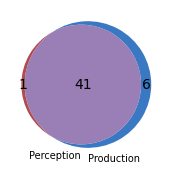

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5*cm, 5*cm))

counts = stats[stats.roi=='STG']['category'].value_counts()
perception_only_count = counts.get('Perception Only', 0)
production_only_count = counts.get('Production Only', 0)
both_count = counts.get('Both', 0)

v=venn2(
    subsets=(perception_only_count, production_only_count, both_count),
    set_labels=('Perception', 'Production'),
    set_colors=(red, blue),
    alpha=0.9,
    ax=ax
)
v.set_labels[0].set_fontsize(7)
v.set_labels[1].set_fontsize(7)

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_3614420/3675645380.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


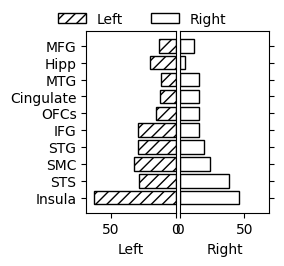

In [14]:
df = stats

counts = (
    df.groupby(['roi', 'hemi'])['electrode']
      .nunique()
      .unstack(fill_value=0)
)
counts = counts.rename(columns={'L': 'Left', 'R': 'Right'})
counts['total'] = counts['Left'] + counts['Right']
counts = counts.sort_values('total', ascending=True)

# 如果只要 top10：
plot_df = counts.tail(10)


rois = plot_df.index
left_counts  = plot_df['Left']
right_counts = plot_df['Right']
total_counts = plot_df['total']

fig, (axL, axR) = plt.subplots(
    1, 2, figsize=(6*cm, 6*cm), sharey=True,
    gridspec_kw={'wspace': 0.05}
)

# -------- 左脑 subplot（画在左边，x 轴反向 -> 往左伸出去） --------
axL.barh(
    rois,
    left_counts,
    color='white',
    edgecolor='black',
    hatch='///',
    label='Left',
)
axL.invert_xaxis()      # 让条往左
axL.set_xlabel('Left')
axL.yaxis.tick_left()

# -------- 右脑 subplot --------
axR.barh(
    rois,
    right_counts,
    color='white',
    edgecolor='black',
    label='Right',
)
axR.set_xlabel('Right')
axR.yaxis.tick_right()

# y 轴从 top10 中最大数量的那个开始在最上面（跟你代码一致）
axL.invert_yaxis()

# 根据最大值设一下 x 轴范围（避免写死 0–100）
max_val = max(left_counts.max(), right_counts.max())
axR.set_xlim(0, max_val * 1.1)
axL.set_xlim(max_val * 1.1, 0)

handlesL, labelsL = axL.get_legend_handles_labels()
handlesR, labelsR = axR.get_legend_handles_labels()

fig.legend(
    handlesL + handlesR, labelsL + labelsR,
    loc='upper center', ncol=2, frameon=False
)

plt.tight_layout()
plt.show()

# Barplot

In [15]:
stats_path = BIDSPath(
    root=f'../results/PhonemeSequence',
    datatype='HGA',
    suffix='coord',
    check=False,
)
coords = []
for path in tqdm(stats_path.match()):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)
# drop nan channels
coords = coords[~coords.x.isna()]
coords = coords[~coords.roi.isin(['Unknown','WM'])]

# combine IFG and IFGs
coords.loc[coords.roi == 'IFGs', 'roi'] = 'IFG'
# rename INS to 'Insula'
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
coords.loc[coords.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'CG', 'roi'] = 'Cingulate'

coords.loc[coords.roi == 'Subcentral', 'roi'] = 'SMC'

coords.head()

100%|██████████| 88/88 [00:01<00:00, 57.31it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,label,roi,hemi
0,D0019_ROG1-2,20.731562,-95.433053,-4.406237,-0.002114,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
1,D0019_ROG2-3,18.712896,-94.417750,6.523434,0.015127,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
2,D0019_ROG3-4,17.039880,-94.822626,17.317047,0.062083,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
3,D0019_ROG4-5,16.298644,-91.860079,29.446276,0.044187,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_sup,sOccG,R
4,D0019_ROG5-6,13.397947,-84.402838,39.447554,-0.001664,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_sup,sOccG,R


In [16]:
# 只保留 significant 的电极
# sig = coords

description = 'perception'
# sig = coords[(coords['significant']) & (coords['description'] == description)]

sig = coords[(coords['description'] == description)]

# 每个 roi、每个 hemi 的电极数（按 channel 去重）
cnt = (
    sig.groupby(['roi', 'hemi'])['channel']
       .nunique()
       .reset_index(name='n_sig')
)
# 变成行=ROI，列=左右脑 的表
plot_df = (
    cnt.pivot(index='roi', columns='hemi', values='n_sig')
       .fillna(0)
)

# 根据你实际的 hemi 值改列名（例如 'L'/'R' 或 'lh'/'rh'）
# 这里假设是 'L' / 'R'
if 'L' in plot_df.columns and 'R' in plot_df.columns:
    left_col, right_col = 'L', 'R'
else:
    # 例如是 'lh' / 'rh'
    left_col, right_col = 'lh', 'rh'

plot_df = plot_df.rename(columns={left_col: 'Left', right_col: 'Right'})
plot_df['total'] = plot_df[['Left', 'Right']].sum(axis=1)

# 按 total 从大到小排序（和你示意图一样从上到下数量递减）
plot_df = plot_df.sort_values('total', ascending=False)
plot_df = plot_df.head(10)
plot_df.head()

hemi,Left,Right,unknown,total
roi,,,,
STS,139.0,97.0,0.0,236.0
Insula,127.0,100.0,0.0,227.0
SMC,129.0,93.0,0.0,222.0
Cingulate,64.0,80.0,0.0,144.0
OFCs,84.0,57.0,0.0,141.0


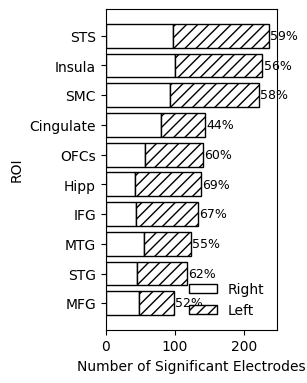

In [17]:
rois = plot_df.index
left_counts = plot_df['Left']
right_counts = plot_df['Right']
total_counts = plot_df['total']

fig, ax = plt.subplots(figsize=(8*cm, 10*cm))

# 右半球：白色、空心
ax.barh(
    rois,
    right_counts,
    color='white',
    edgecolor='black',
    label='Right',
)

ax.barh(
    rois,
    left_counts,
    left=right_counts,
    color='white',
    edgecolor='black',
    hatch='///',
    label='Left',
)

# 在条形右侧写上“左侧占比”的百分比（可选）
left_pct = (left_counts / total_counts * 100).round().astype(int)

for y, total, p in zip(rois, total_counts, left_pct):
    ax.text(
        total + 2,  
        y,
        f'{p}%',
        va='center',
        fontsize=9,
    )

ax.set_xlabel('Number of Significant Electrodes')
ax.set_ylabel('ROI')

# y axis order 
ax.invert_yaxis()

# legend
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_3614420/3550438400.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


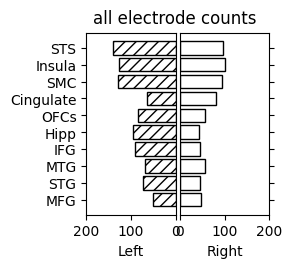

In [18]:
rois = plot_df.index
left_counts  = plot_df['Left']
right_counts = plot_df['Right']
total_counts = plot_df['total']

fig, (axL, axR) = plt.subplots(
    1, 2, figsize=(6*cm, 6*cm), sharey=True,
    gridspec_kw={'wspace': 0.05}
)

# -------- 左脑 subplot（画在左边，x 轴反向 -> 往左伸出去） --------
axL.barh(
    rois,
    left_counts,
    color='white',
    edgecolor='black',
    hatch='///',
    label='Left',
)
axL.invert_xaxis()      # 让条往左
axL.set_xlabel('Left')
axL.yaxis.tick_left()

# -------- right --------
axR.barh(
    rois,
    right_counts,
    color='white',
    edgecolor='black',
    label='Right',
)
axR.set_xlabel('Right')
axR.yaxis.tick_right()

# left_pct = (left_counts / total_counts * 100).round().astype(int)
# for y, total, p in zip(rois, total_counts, left_pct):
#     # total 这里只用来确定位置，可以用 max(left,right)
#     axR.text(
#         max(left_counts.loc[y], right_counts.loc[y]) + 1,
#         y,
#         f'{p}%',
#         va='center',
#         fontsize=8,
#     )

axL.invert_yaxis()

axR.set_xlim(0, 200)
axL.set_xlim(200, 0)


handlesL, labelsL = axL.get_legend_handles_labels()
handlesR, labelsR = axR.get_legend_handles_labels()

# fig.legend(
#     handlesL + handlesR, labelsL + labelsR,
#     loc='upper center', ncol=2, frameon=False
# )

plt.suptitle(f'all electrode counts')

plt.tight_layout()

fig.savefig(f'../img/HGAs/barplot_{description}.svg', dpi=300, bbox_inches='tight')

# Brain HGA

In [19]:
stats_path = BIDSPath(
    root=f'../results/PhonemeSequence(car)',
    datatype='HGA',
    suffix='coord',
    check=False,
)
coords = []
for path in tqdm(stats_path.match()):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)

# combine IFG and IFGs
coords.loc[coords.roi == 'IFGs', 'roi'] = 'IFG'
# rename INS to 'Insula'
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
coords.loc[coords.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'CG', 'roi'] = 'Cingulate'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'PrG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'PoG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'Subcentral', 'roi'] = 'SMC'
coords.loc[coords.roi == 'Central', 'roi'] = 'SMC'

coords.head()

100%|██████████| 96/96 [00:01<00:00, 54.24it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,label,roi,hemi
0,ROG1,21.327845,-96.243659,-9.592295,0.030245,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
1,ROG2,20.135281,-94.622454,0.779821,0.012121,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
2,ROG3,17.290512,-94.213040,12.267046,0.005926,False,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
3,ROG4,16.789249,-95.432212,22.367048,0.043211,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
4,ROG5,15.808040,-88.287945,36.525507,0.027893,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_sup,sOccG,R


In [20]:
coords.roi.unique()

array(['OPC', 'sOccG', 'iOccGs', 'mOccG', 'AG', nan, 'SMC', 'SPL', 'PCun',
       'Cun', 'Cingulate', 'LinG', 'WM', 'FuG', 'PhG', 'Cb',
       'TransvFrontopol', 'MFG', 'SFG', 'SFGs', 'Insula', 'STG',
       'Unknown', 'Thal', 'STS', 'PCuns', 'SMG', 'GRect', 'OFCs', 'MFGs',
       'LatV', 'IFG', 'Sylvian', 'OFC', 'MTG', 'TP', 'ITG', 'CGs',
       'LinGs', 'FuGs', 'Paracentral', 'Amyg', 'Hipp', 'InfLatV', 'CP',
       'Caud', 'Put', 'ctx-lh-unknown', 'CC', 'IPL', 'VDC', 'OccS',
       'CC_Central', 'Calcarine', 'CC_Mid_Anterior', 'CollatAnt',
       'CC_Anterior', 'ctx-rh-unknown', 'Right-Pallidum', 'Left-Pallidum',
       '3rd-Ventricle', 'BrainStem', 'CSF'], dtype=object)

In [21]:
sig_cord = coords[coords['significant'] == True]
sig_cord.head()

,channel,x,y,z,HGA,significant,subject,task,band,description,label,roi,hemi
3,ROG4,16.789249,-95.432212,22.367048,0.043211,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_Pole_occipital,OPC,R
4,ROG5,15.808040,-88.287945,36.525507,0.027893,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_sup,sOccG,R
11,ROG12,22.566772,-79.649725,44.121076,0.059456,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_sup,sOccG,R
12,ROG13,40.932160,-86.817226,-11.961574,0.038569,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_and_S_occipital_inf,iOccGs,R
15,ROG16,40.232501,-86.768337,24.902793,0.018239,True,D0019,PhonemeSequence,highgamma,perception,ctx_rh_G_occipital_middle,mOccG,R


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-03 13:18:01.165 ( 431.565s) [    7F88B3CB7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x21454cf0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-03 13:18:01.207 ( 431.608s) [    7F88B3CB7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1ff20c30): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


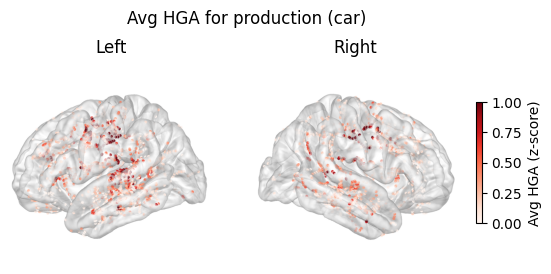

In [26]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 创建左右半球 Brain
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.6, size=(700*cm, 700*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.6, size=(700*cm, 700*cm)
)

description = 'production'

# pick = ['Insula','STG','SMC']
pick = sig_cord.roi.unique()
cord = sig_cord[sig_cord.roi.isin(pick) & (sig_cord.description == description)][['x', 'y', 'z']].values
HGAs = sig_cord[(sig_cord.roi.isin(pick) & (sig_cord.description == description))]['HGA'].values

# ============ 分离左右半球的电极 ============
mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 计算全局色标范围（基于所有电极）
vmin = np.nanpercentile(HGAs, 2)
vmax = np.nanpercentile(HGAs, 96)

vmin = 0
vmax = 1

# ============ left hemisphere ============
if mask_lh.any():
    # 加载左半球 pial 表面
    lh_surf_path = f"{recon_dir}/fsaverage/surf/lh.pial"
    lh_coords_surf, _ = mne.read_surface(lh_surf_path)
    
    # 投影左半球电极
    lh_tree = cKDTree(lh_coords_surf)
    _, lh_indices = lh_tree.query(cord[mask_lh])
    lh_cord_projected = lh_coords_surf[lh_indices]
    
    # 创建左半球点云
    lh_cloud = pv.PolyData(lh_cord_projected)
    lh_cloud["HGA"] = HGAs[mask_lh]
    
    # 绘制左半球
    lh_brain._renderer.plotter.add_mesh(
        lh_cloud,
        render_points_as_spheres=True,
        point_size=20,
        scalars="HGA",
        cmap='Reds',
        clim=(vmin, vmax),
        lighting=False,
        smooth_shading=False,
        opacity=0.9,
        show_scalar_bar=False
    )

# ============ right hemisphere ============
if mask_rh.any():
    # 加载右半球 pial 表面
    rh_surf_path = f"{recon_dir}/fsaverage/surf/rh.pial"
    rh_coords_surf, _ = mne.read_surface(rh_surf_path)
    
    # 投影右半球电极
    rh_tree = cKDTree(rh_coords_surf)
    _, rh_indices = rh_tree.query(cord[mask_rh])
    rh_cord_projected = rh_coords_surf[rh_indices]
    
    # 创建右半球点云
    rh_cloud = pv.PolyData(rh_cord_projected)
    rh_cloud["HGA"] = HGAs[mask_rh]
    
    # 绘制右半球
    rh_brain._renderer.plotter.add_mesh(
        rh_cloud,
        render_points_as_spheres=True,
        point_size=20,
        scalars="HGA",
        cmap='Reds',
        clim=(vmin, vmax),
        lighting=False,
        smooth_shading=False,
        opacity=0.9,
        show_scalar_bar=False
    )

# ============ set label and angle ============

labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# for lab in labels:
#     name = lab.name  # 'G_insular_short-lh', 'G_temp_sup-Lateral-lh', 'S_temporal_sup-lh'

#     # Insula
#     if 'ins' in name.lower():  # G_Ins_lg_and_S_cent_ins, G_insular_short
#         if lab.hemi == 'lh':
#             lh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)
#         elif lab.hemi == 'rh':
#             rh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)

#     if ('G_temp_sup' in name):
#         if lab.hemi == 'lh':
#             lh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)
#         elif lab.hemi == 'rh':
#             rh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=350)
    brain._renderer.plotter.window_size = [1400, 1400]

# 截图并显示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

import matplotlib as mpl
cmap = plt.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax1, ax2],         # 绑定到两个子图
    fraction=0.046, pad=0.04,  # 位置调节
    location='right',           # 右侧竖直色条
    shrink=0.5
)
cbar.set_label('Avg HGA (z-score)', rotation=90)

plt.suptitle(f"Avg HGA for {description} (car)")

# 关闭 Brain 对象
lh_brain.close()
rh_brain.close()

fig.savefig(f'../img/HGAs/whole_brain_HGA_pial_{description}.svg', dpi=300, bbox_inches='tight')

In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 创建左右半球 Brain
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(650*cm, 650*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(650*cm, 650*cm)
)

description = 'perception'
roi = ['Insula']
cord = sig_cord[(sig_cord.description == description) & (sig_cord.roi.isin(roi))][['x', 'y', 'z']].values
HGAs = sig_cord[(sig_cord.description == description) & (sig_cord.roi.isin(roi))]['HGA'].values

# ============ 分离左右半球的电极 ============
mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 计算全局色标范围（基于所有电极）
vmin = np.nanpercentile(HGAs, 2)
vmax = np.nanpercentile(HGAs, 95)

vmin = 0
vmax = 1

# ============ left hemi ============
if mask_lh.any():
    # 加载左半球 pial 表面
    lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
    lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
    lh_coords_pial, _ = mne.read_surface(lh_pial_path)
    lh_coords_infl, _ = mne.read_surface(lh_infl_path)
    lh_tree = cKDTree(lh_coords_pial)
    _, lh_indices = lh_tree.query(cord[mask_lh])
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    lh_cloud = pv.PolyData(lh_cord_on_infl)
    lh_cloud["HGA"] = HGAs[mask_lh]
    lh_brain._renderer.plotter.add_mesh(
        lh_cloud,
        render_points_as_spheres=True,
        point_size=20,
        scalars="HGA",
        cmap='Reds',
        clim=(vmin, vmax),
        lighting=False,
        smooth_shading=False,
        opacity=1,
        show_scalar_bar=False
    )
    
# ============ right hemi ============
if mask_rh.any():
    # 加载右半球 pial 表面
    rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
    rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
    rh_coords_pial, _ = mne.read_surface(rh_pial_path)
    rh_coords_infl, _ = mne.read_surface(rh_infl_path)
    rh_tree = cKDTree(rh_coords_pial)
    _, rh_indices = rh_tree.query(cord[mask_rh])
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    rh_cloud = pv.PolyData(rh_cord_on_infl)
    rh_cloud["HGA"] = HGAs[mask_rh]
    rh_brain._renderer.plotter.add_mesh(
        rh_cloud,
        render_points_as_spheres=True,
        point_size=20,
        scalars="HGA",
        cmap='Reds',
        clim=(vmin, vmax),
        lighting=False,
        smooth_shading=False,
        opacity=0.9,
        show_scalar_bar=False
    )

# ============ 设置视角和截图 ============
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

for lab in labels:
    name = lab.name  # 'G_insular_short-lh', 'G_temp_sup-Lateral-lh', 'S_temporal_sup-lh'

    # Insula
    if 'ins' in name.lower():  # G_Ins_lg_and_S_cent_ins, G_insular_short
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)

    # STG: superior temporal gyrus / sulcus
    # if ('G_temp_sup' in name) or ('S_temporal_sup' in name):

    if ('G_temp_sup' in name):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)

    # SMC: pre/postcentral + paracentral + subcentral + central
    # smc_keys = [
    #     'G_precentral',
    #     # 'S_precentral-sup-part',
    #     # 'S_precentral-inf-part',
    #     'G_postcentral',
    #     # 'S_postcentral',
    #     # 'G_and_S_paracentral',
    #     'G_and_S_subcentral',
    #     # 'S_central',
    # ]
    # if any(k in name for k in smc_keys):
    #     if lab.hemi == 'lh':
    #         # lh_brain.add_label(lab, borders=False, color=(0.8, 0.0, 0.0), alpha=0.4, )
    #         lh_brain.add_label(lab, borders=True, color='black', alpha=0.7, )
    #     elif lab.hemi == 'rh':
    #         # rh_brain.add_label(lab, borders=False, color=(0.8, 0, 0), alpha=0.4,)
    #         rh_brain.add_label(lab, borders=True, color='black', alpha=0.7,)
            
for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

# 截图并显示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

import matplotlib as mpl
cmap = plt.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax1, ax2],         
    fraction=0.046, pad=0.04,  
    location='right',           
    shrink=0.5
)
cbar.set_label('Avg HGA (z-score)', rotation=90)
plt.suptitle(f"Avg HGA for {description} (car) (just Insula)")

lh_brain.close()
rh_brain.close()

fig.savefig(f'../img/HGAs/whole_brain_HGA_inflated_{description}.svg', dpi=300, bbox_inches='tight')

NameError: name 'recon_dir' is not defined